In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_parquet("data/raw/france.parquet")
data.dropna(axis=0, how='any', inplace=True)

position = pd.read_csv("data/raw/postesSynop.csv", sep=";")

Id = position["ID"].astype(str)
for i in range(len(Id)):
    if len(Id[i]) < 5:
        Id[i] = '0' + Id[i]

production = pd.read_parquet("data/raw/franceagrimer-rdts-surfs-multicrops.parquet")
production = production.drop(production[production["n_dep"] == "2A"].index)
production = production.drop(production[production["n_dep"] == "2B"].index)
production = production.drop(production[production["n_dep"].astype(int) > 95].index)

provinces = {7005: 80, 7015: 59, 7020: 50, 7027: 14, 7037: 76, 7072: 51, 7110: 29, 7117: 22, 7130: 35, 7139: 61, 7149: 91, 7168: 10, 7181: 54, 7190: 67, 7207: 56, 7222: 44, 7240: 37, 7255: 18, 7280: 21, 7299: 68, 7314: 17, 7335: 86, 7434: 87, 7460: 63, 7471: 43, 7481: 69, 7510: 33, 7535: 46, 7558: 12, 7577: 26, 7591: 5, 7607: 40, 7621: 65, 7627: 9, 7630: 31, 7643: 34, 7650: 13, 7661: 83, 7690: 6, 7747: 66, 67005: 10}

crops = production["crop"].unique()
stations = data["id_sta"].unique()

In [3]:
lr = LinearRegression()

# Single element prediction

In [4]:
times = 1000

In [5]:
def init_y():
    for i in total_rain:
        n_dep0, year = i.split('_')
        r_year = production['n_dep'].map(lambda x : x == n_dep0)
        r_crop = production['crop'].map(lambda x : x == crop)
        rdt = production[r_year & r_crop]["rdt_" + year].values
        if rdt.size > 0:
            if rdt[0]:
                total_OP_rdt[i] = rdt[0]

In [6]:
def init():
    init_y()
    return init_list()

In [7]:
def predict_zero():
    predict_zero = OP_rdt_array.mean()
    
    RMSE = math.sqrt(((predict_zero - OP_rdt_array) ** 2).sum() / len(OP_rdt_array))
    rRMSE = RMSE / OP_rdt_array.mean()
    
    return rRMSE

In [8]:
def predict_n(n, times):
    if n == 0:
        return predict_zero()

    sum_RMSE = 0
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, OP_rdt_array, test_size=0.2)
        X_train_n = X_train
        X_test_n = X_test
        for i in range(2, n + 1):
            X_train_n = np.concatenate([X_train ** i, X_train_n], axis=1)
            X_test_n = np.concatenate([X_test ** i, X_test_n], axis=1)
        
        lr.fit(X_train_n, y_train)
        y_predict_n = lr.predict(X_test_n)
        
        RMSE = math.sqrt(((y_predict_n - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        
        sum_RMSE += rRMSE

    return sum_RMSE / times

In [9]:
def test_degree_n(times):
    degree = np.linspace(0, 10, 11)
    for i in degree:
        rRMSE_degree[crop + i.astype(int).astype(str)] = predict_n(i.astype(int), times)

In [10]:
def draw():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    for crop in crops:
        rRMSE_plot = []
        x_plot = np.linspace(0, 10, 11)
        for i in range(11):
            rRMSE_plot.append(rRMSE_degree[crop + str(i)])
        plt.plot(x_plot, rRMSE_plot)
    plt.legend(crops)

## rr24

In [11]:
def init_x():
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            year_position = 0

            for j in range(2017, 2023):
                rain = 0
                for k in range(year_position, len(data_station)):
                    if data_station.index[k].year == j:
                        rain += data_station["rr24"][k]
                    else:
                        year_position = k
                        break
                total_rain[str(provinces[i]) + "_" + str(j)] = rain

In [12]:
def init_list():
    data_list = []
    OP_rdt_list = []

    for i in total_OP_rdt:
        if i in total_rain:
            data_list.append(np.array([total_rain[i]]))
            OP_rdt_list.append(total_OP_rdt[i])

    data_list = np.array(data_list)
    OP_rdt_list = np.array(OP_rdt_list)
    
    return data_list, OP_rdt_list

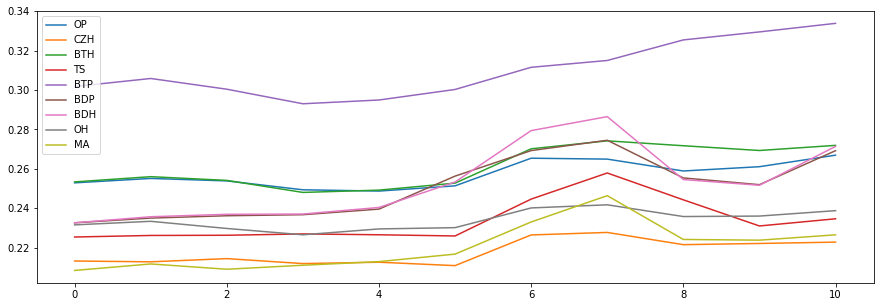

In [13]:
rRMSE_degree = {}
total_rain = {}
total_useful_rad = {}
init_x()

for crop in crops:
    total_OP_rdt = {}

    data_array, OP_rdt_array = init()

    test_degree_n(times)

draw()

In [14]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(11):
        temp_list.append(rRMSE_degree[crop + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP_4': 0.2487602618961626,
 'CZH_5': 0.21096907533039144,
 'BTH_3': 0.2480718364437523,
 'TS_0': 0.2254771996904205,
 'BTP_3': 0.2930159987453777,
 'BDP_0': 0.23267610695447274,
 'BDH_0': 0.23267610695447274,
 'OH_3': 0.22660175844216898,
 'MA_0': 0.20852417057938513}